In [73]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import joblib


In [74]:
df = pd.read_csv("full_testset.csv")
xgb_model = joblib.load("optimized_xgb_model.pkl")

In [75]:
median_val = df["Pct_afro_american"].median()
df["afroamerican_share_class"] = ["High" if val > median_val else "Low" for val in df["Pct_afro_american"]]

In [76]:
def fairness_test(df: pd.DataFrame,
                  prediction_col: str,
                  protected_col: str,
                  protected_type: str = "categorical") -> float:
    """
    Test dependence between categorical predictions (0/1) and protected attribute.

    Args:
        df: DataFrame with columns prediction_col and protected_col
        prediction_col: str, binary predictions (0/1)
        protected_col: str, attribute to test against
        protected_type: "categorical" or "continuous"

    Returns:
        p-value (float)
    """
    preds = df[prediction_col]
    prot  = df.loc[preds.index, protected_col]

    # case A: categorical protected
    if protected_type == "categorical":
        contingency = pd.crosstab(preds, prot)
        if contingency.shape[0] < 2 or contingency.shape[1] < 2:
            return float("nan")
        try:
            _, p, _, _ = stats.chi2_contingency(contingency, correction=False)
        except Exception:
            p = float("nan")
        return float(p)

    # case B: continuous protected
    elif protected_type == "continuous":
        # point-biserial correlation == pearson(preds, prot)
        try:
            _, p = stats.pearsonr(preds, prot)
        except Exception:
            p = float("nan")
        return float(p)

    else:
        raise ValueError("protected_type must be 'categorical' or 'continuous'")


In [77]:
fairness_test(df, "y_pred", "afroamerican_share_class", "categorical")

1.6402865516411186e-47

In [78]:
def fpdp(
    df: pd.DataFrame,
    model,
    protected_col: str,
    protected_type: str,       # "categorical" or "continuous"
    features: list,
    threshold: float = 0.3,
    n_points: int = 15
):
    """
    Fair Partial Dependence Plot (FPDP) for multiple features.
    Returns a list of matplotlib Figures, one per feature.

    For each feature value (categories or grid for numeric):
      - overwrite that feature with fixed value
      - recompute predictions with the given model
      - run fairness_test on predictions vs protected attribute
    """
    figs = []
    feature_cols = [c for c in df.columns if c not in [protected_col, "target"]]

    for feat in features:
        series = df[feat]

        if pd.api.types.is_bool_dtype(series):
            # treat booleans like categorical
            grid = [0, 1]

        elif pd.api.types.is_numeric_dtype(series):
            grid = np.linspace(series.quantile(0.05),
                            series.quantile(0.95),
                            n_points)
        else:
            grid = series.dropna().unique()

        pvals = []
        for val in grid:
            X_mod = df.copy()
            X_mod[feat] = val

            X_input = X_mod[feature_cols].drop(columns=[protected_col], errors="ignore")
            proba = model.predict_proba(X_input)[:, 1]
            preds = (proba >= threshold).astype(int)

            X_mod["_fpdp_pred"] = preds

            pval = fairness_test(
                X_mod,
                prediction_col="_fpdp_pred",
                protected_col=protected_col,
                protected_type=protected_type
            )
            pvals.append(pval)

        # plot
        fig, ax = plt.subplots(figsize=(5, 3))
        if pd.api.types.is_numeric_dtype(df[feat]):
            ax.plot(grid, pvals, marker="o")
        else:
            ax.bar(grid, pvals)

        ax.axhline(0.05, color="red", linestyle="--", linewidth=1)
        ax.set_title(f"FPDP for {feat}")
        ax.set_ylabel("p-value")
        ax.set_xlabel(feat)
        plt.tight_layout()
        plt.show()
        figs.append(fig)
        

    return figs


for more categorical features, enhance df_maxim in eda with more features, just like u got pct american etc... extract prior to encoding

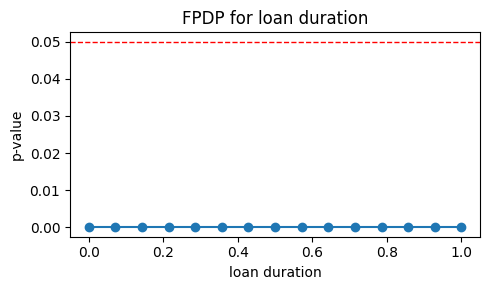

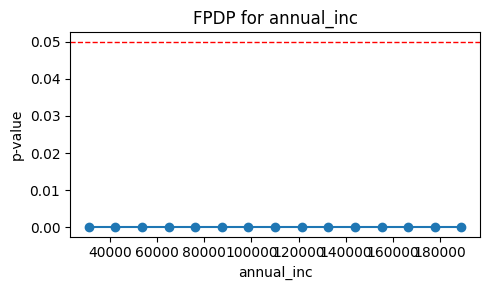

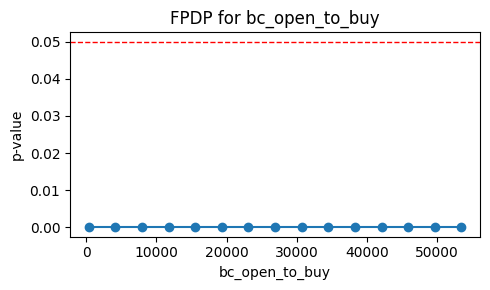

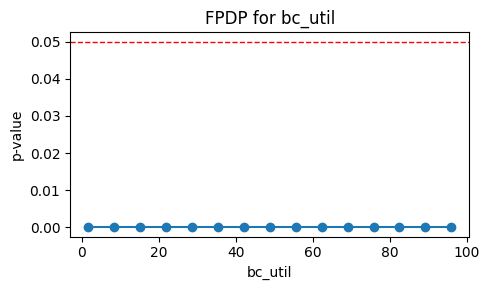

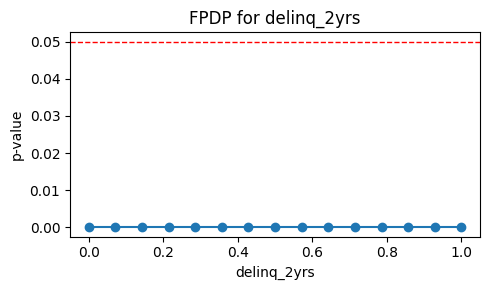

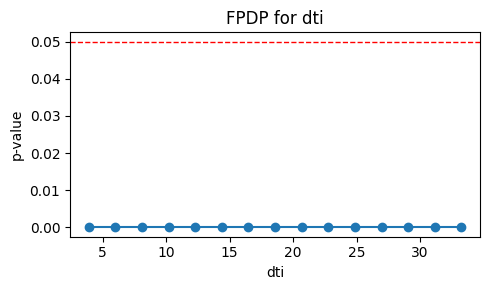

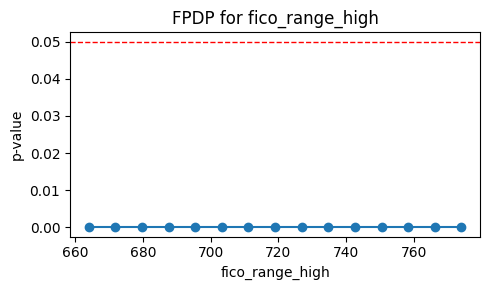

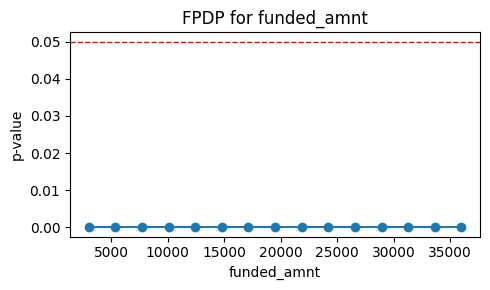

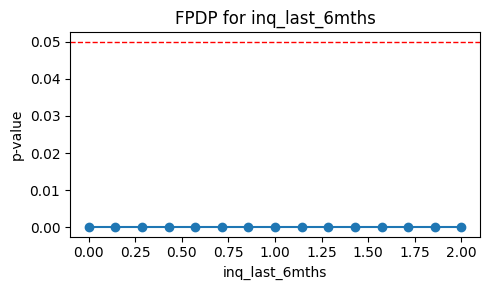

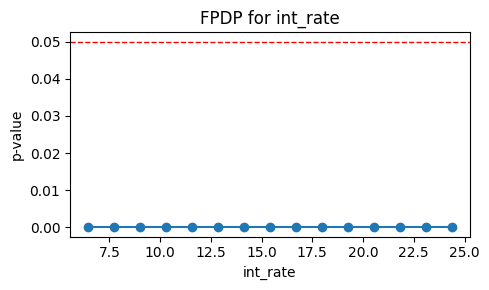

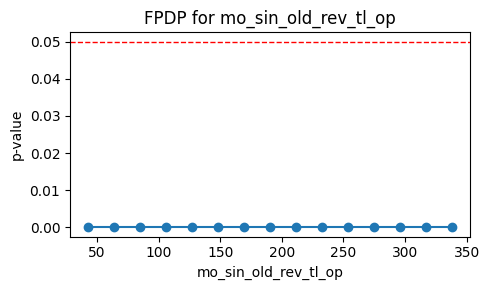

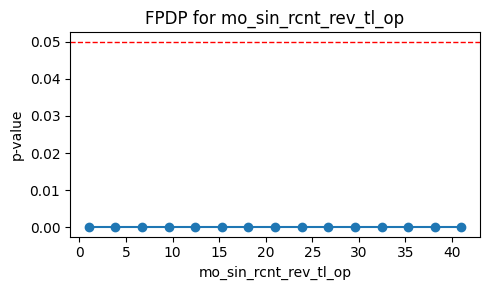

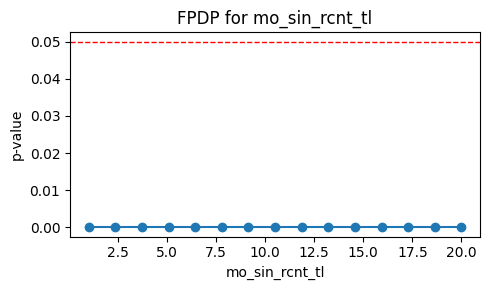

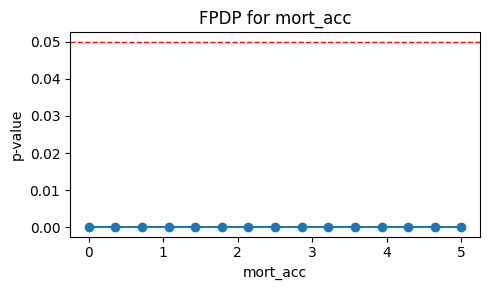

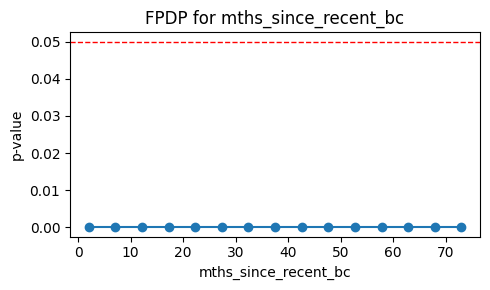

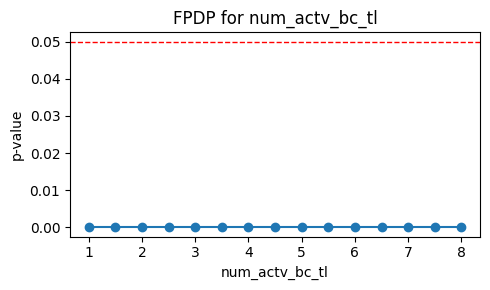

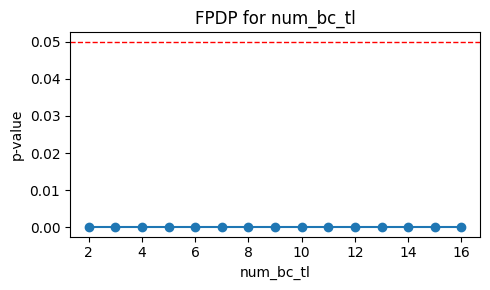

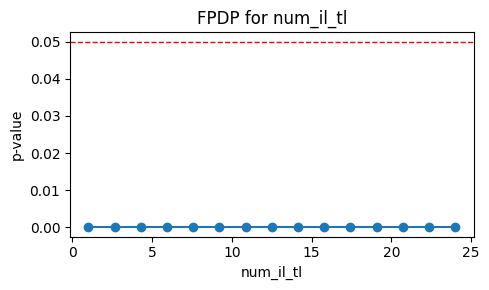

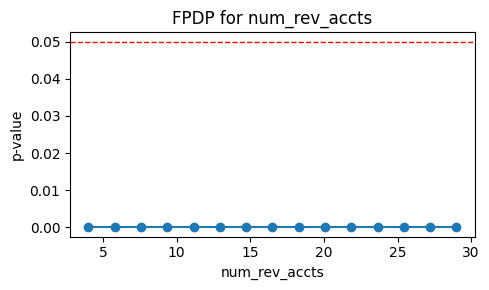

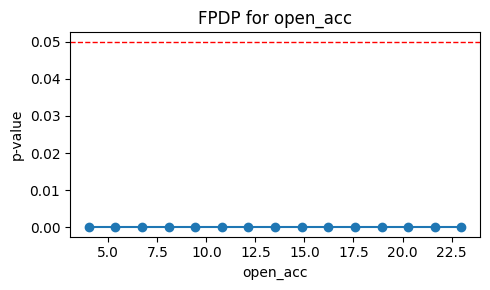

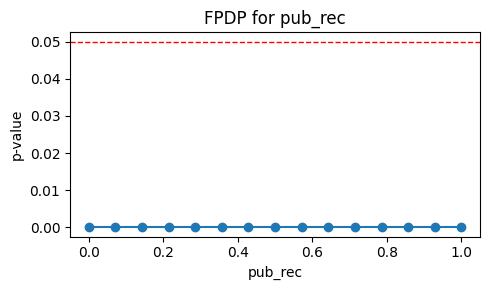

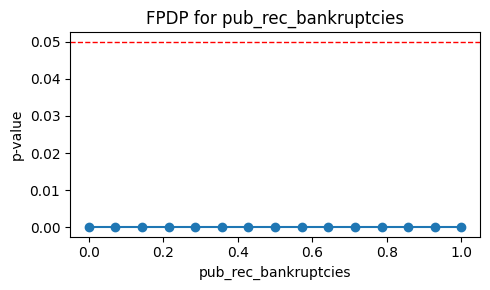

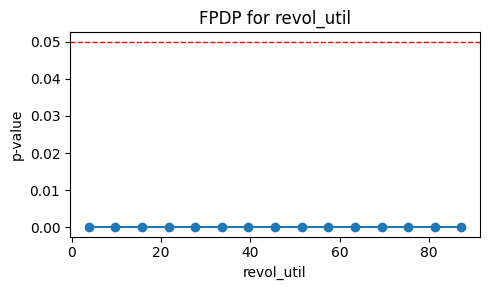

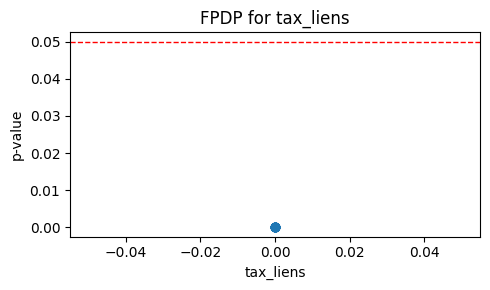

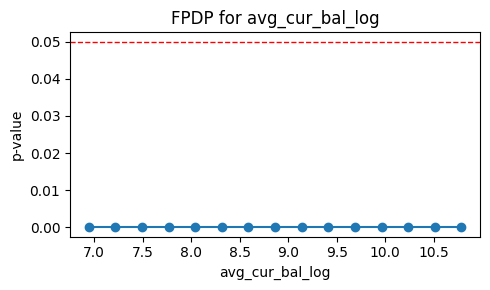

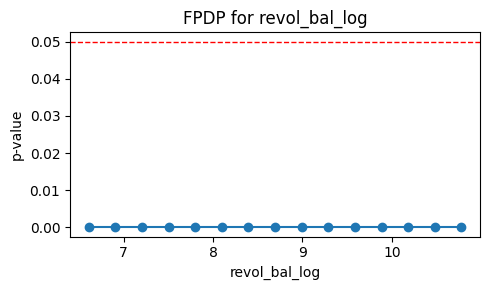

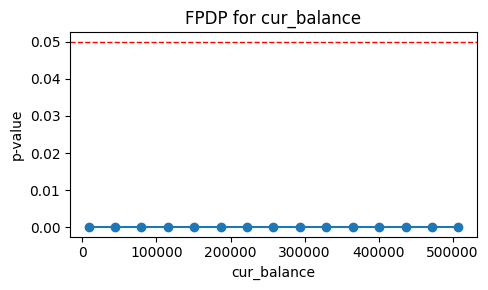

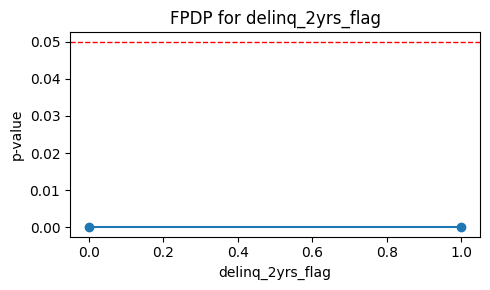

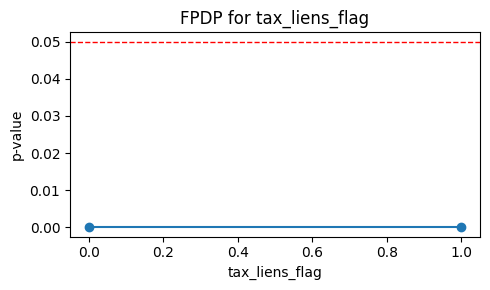

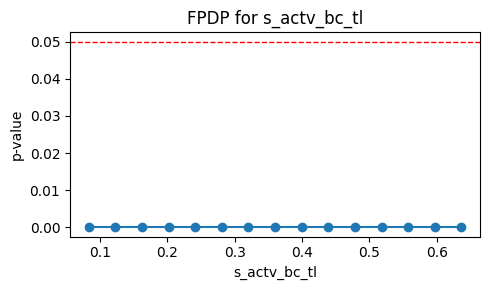

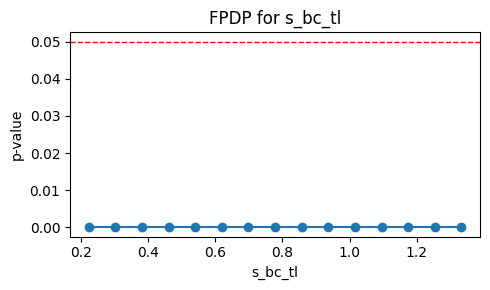

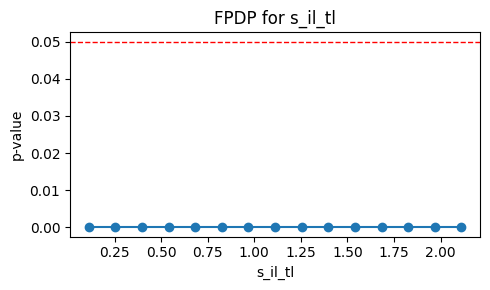

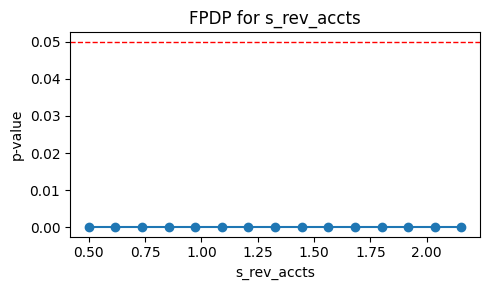

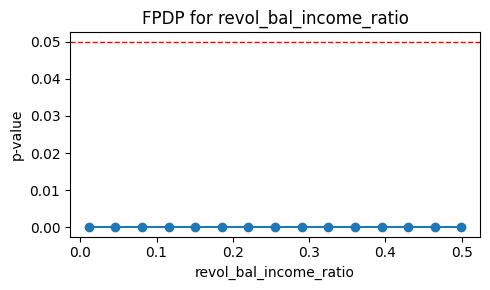

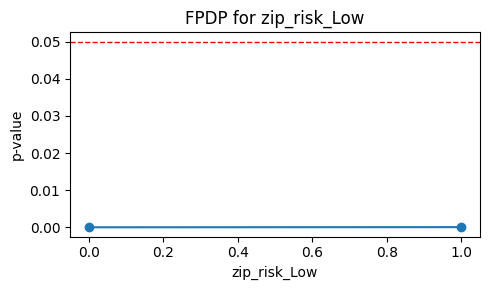

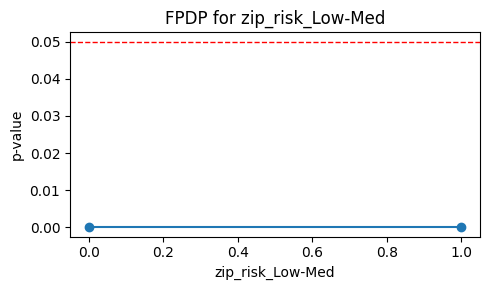

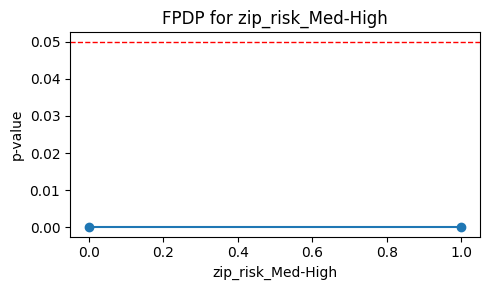

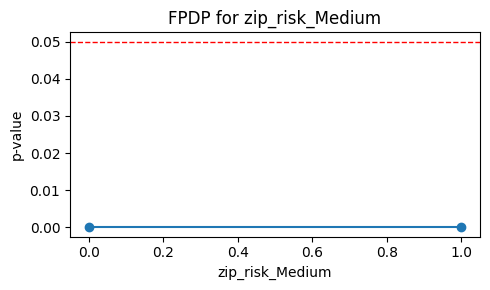

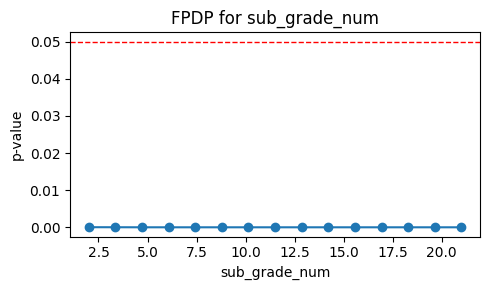

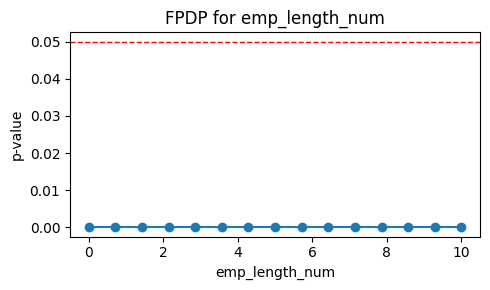

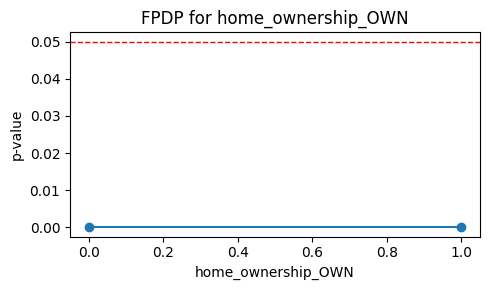

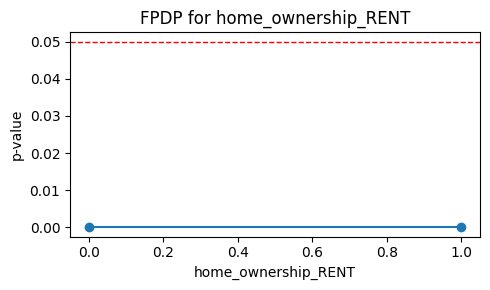

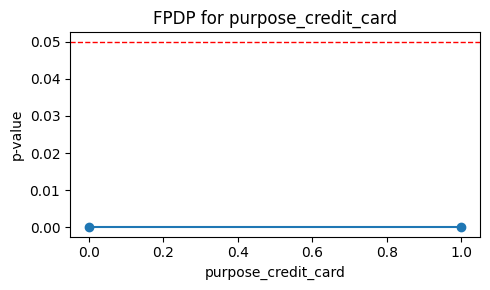

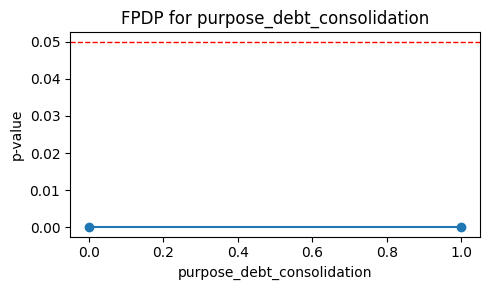

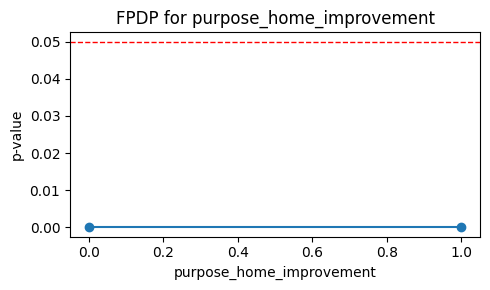

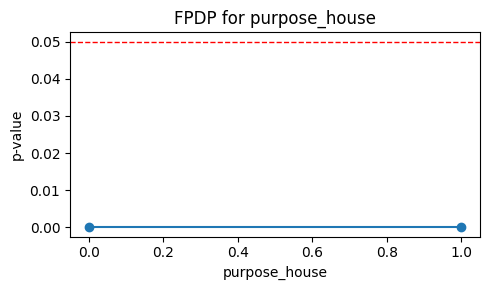

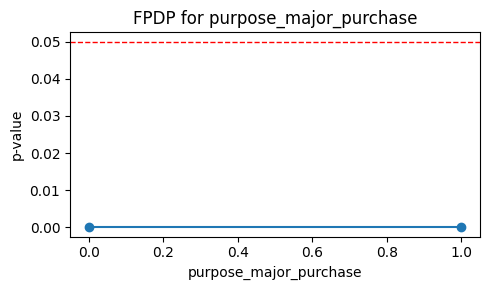

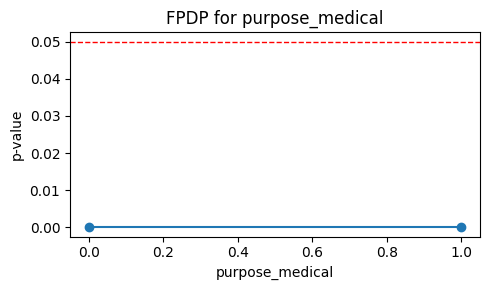

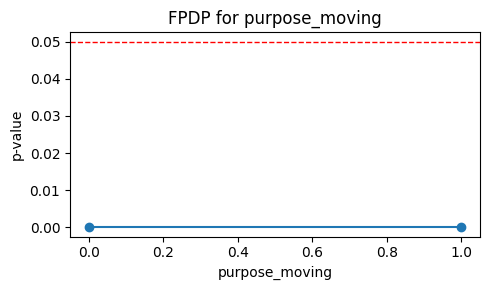

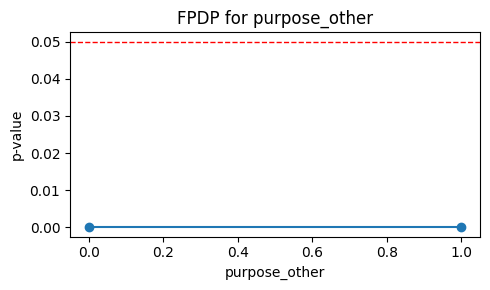

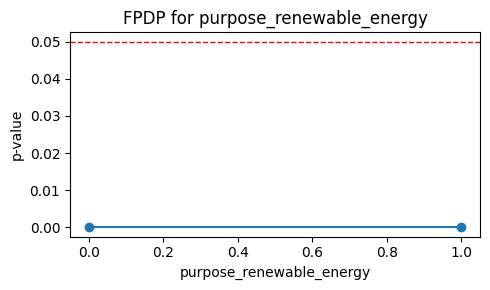

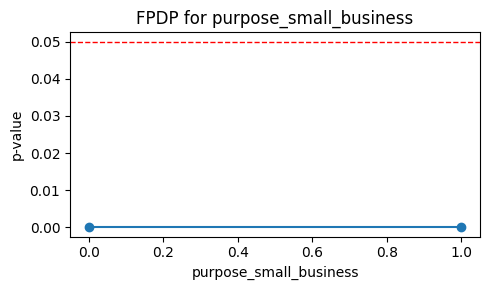

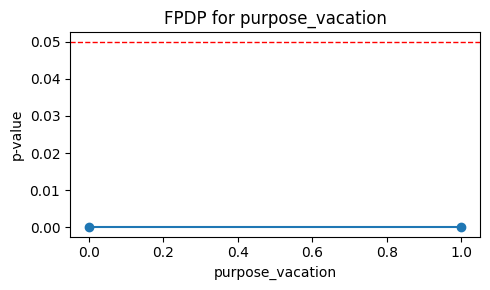

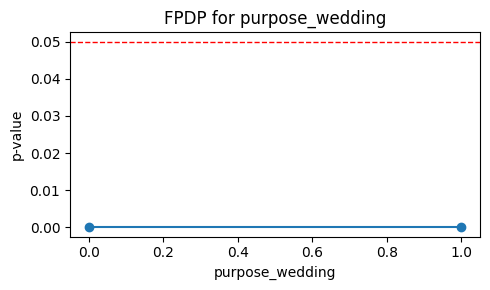

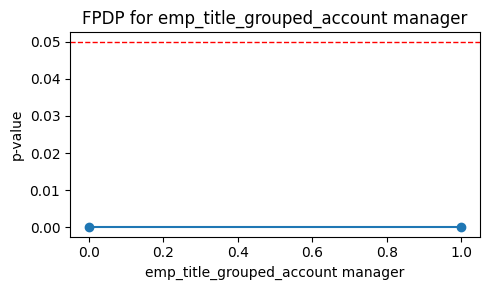

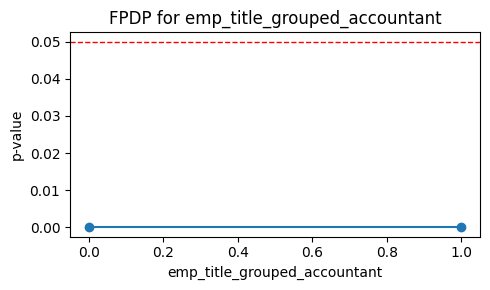

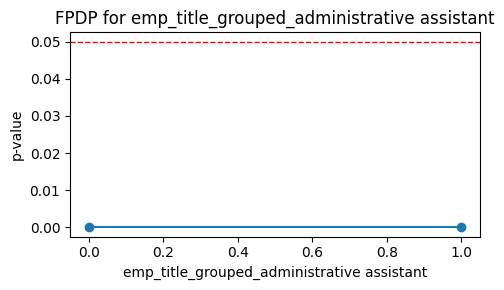

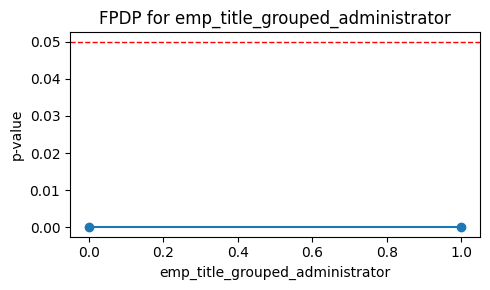

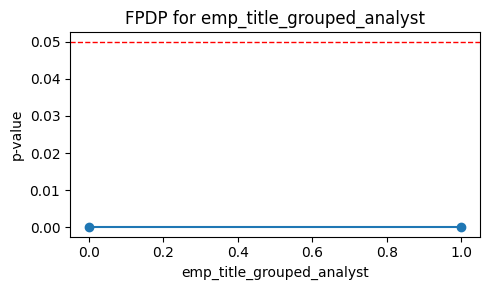

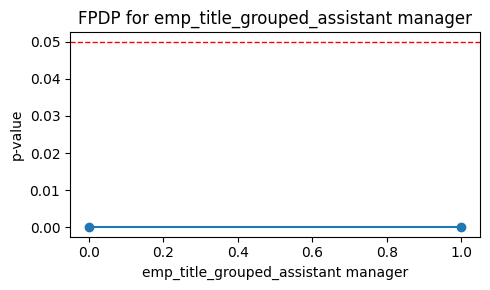

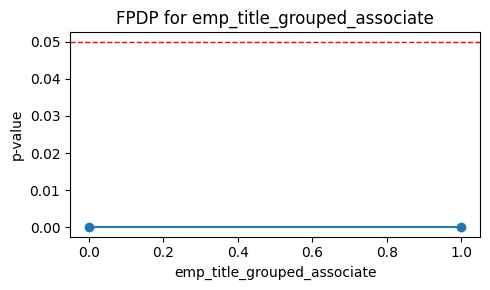

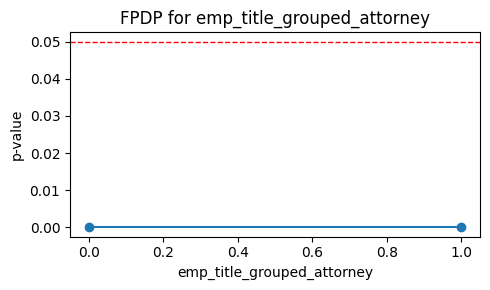

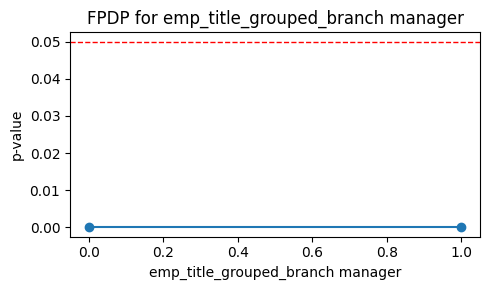

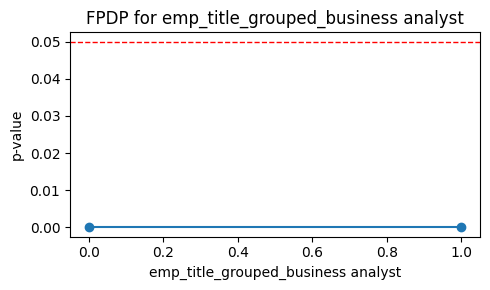

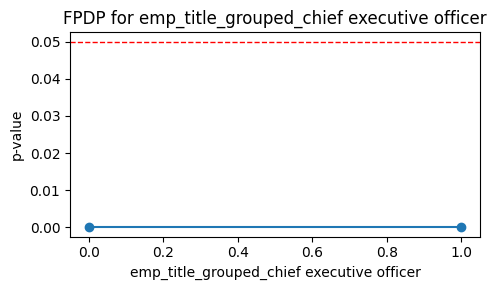

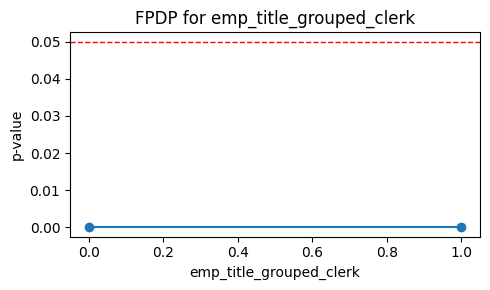

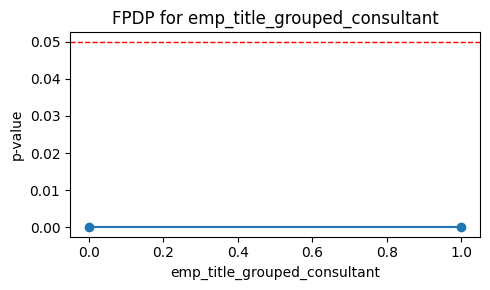

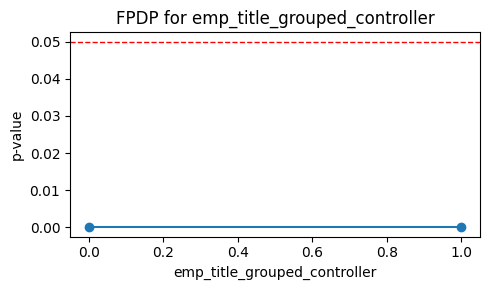

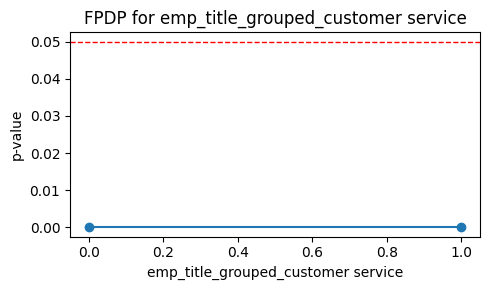

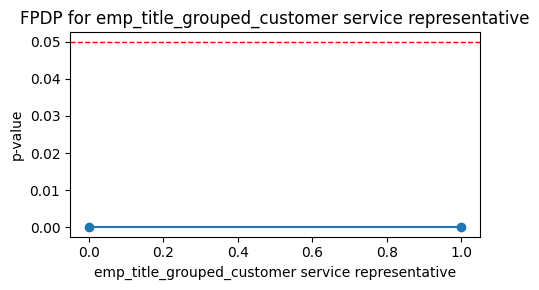

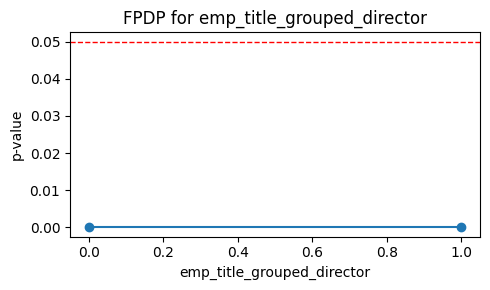

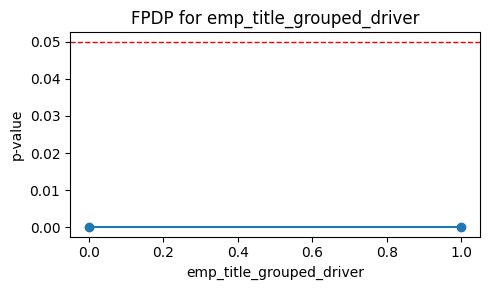

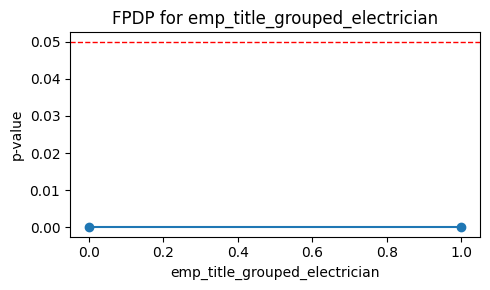

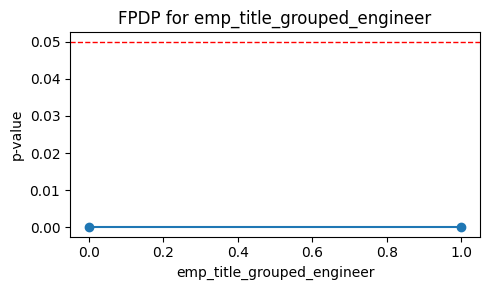

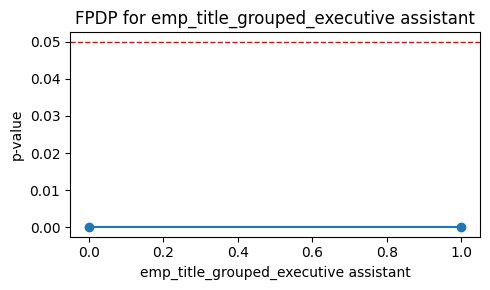

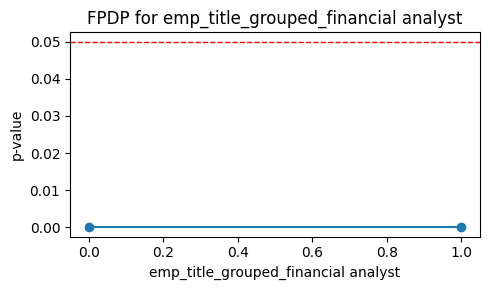

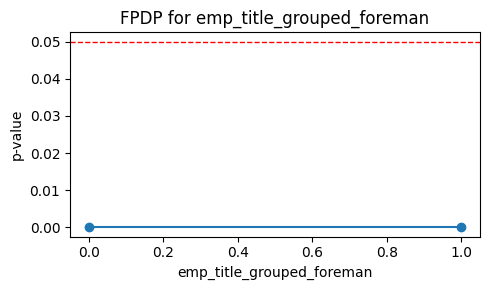

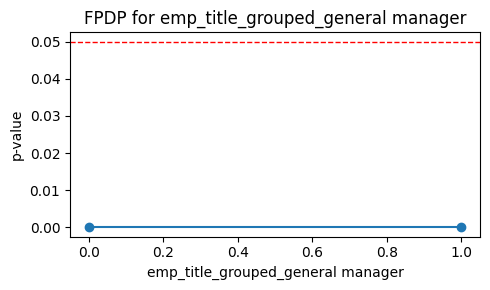

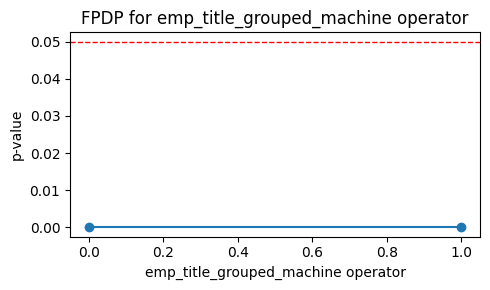

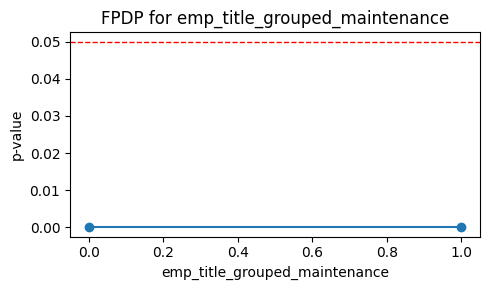

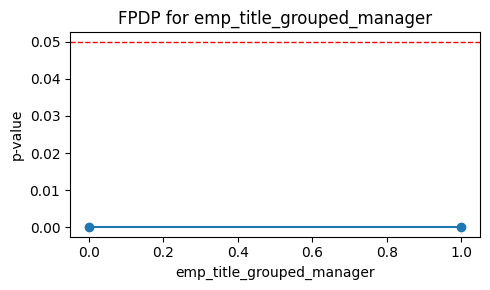

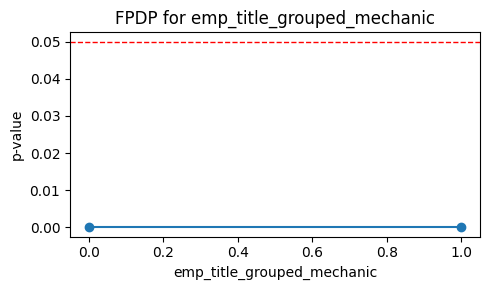

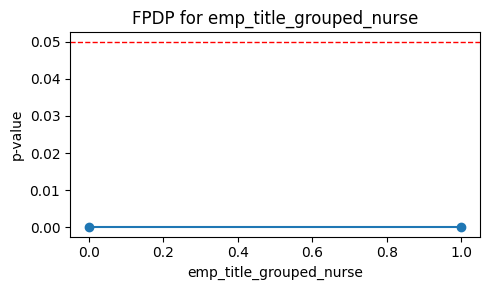

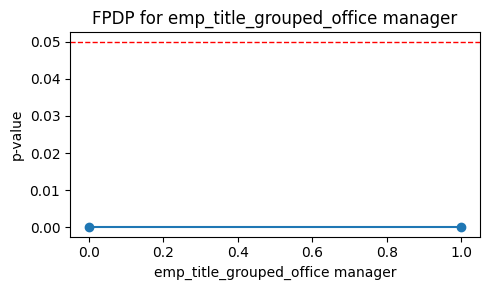

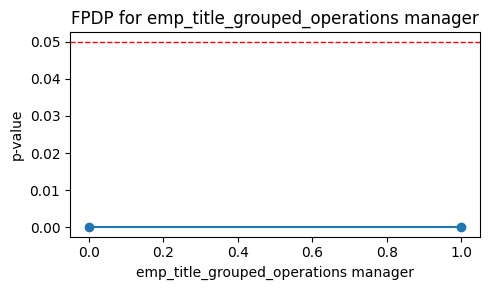

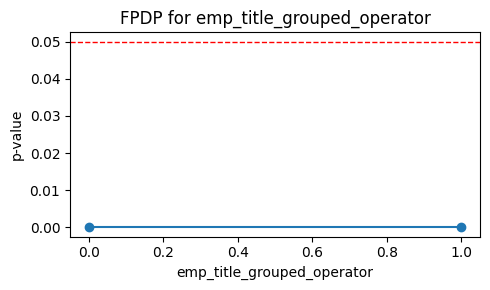

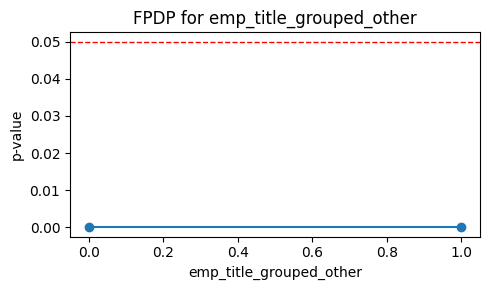

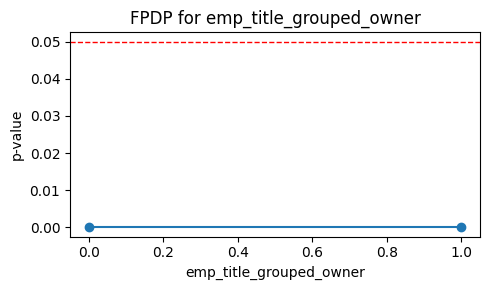

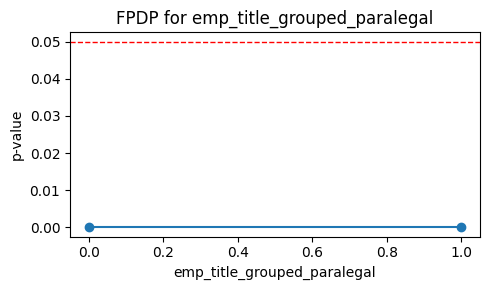

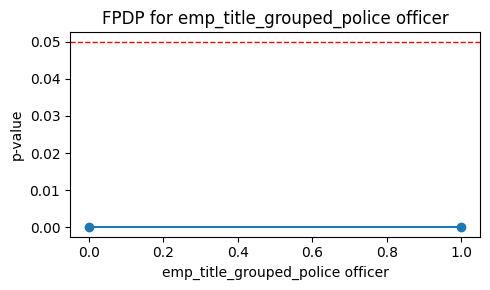

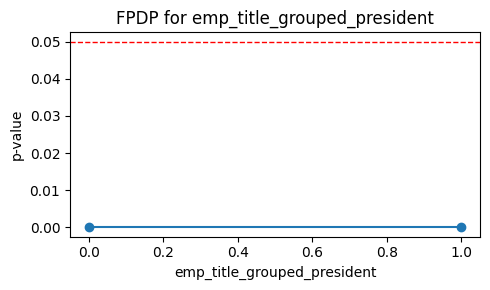

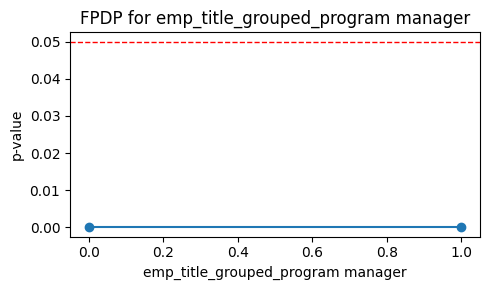

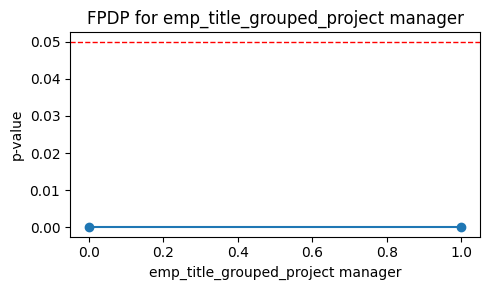

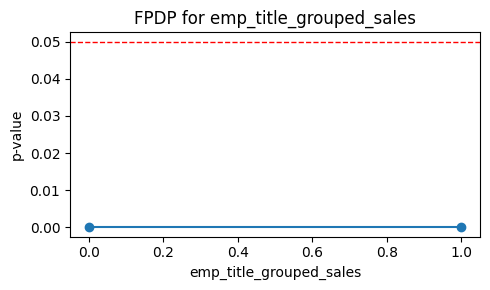

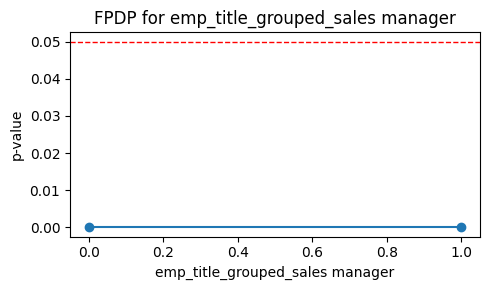

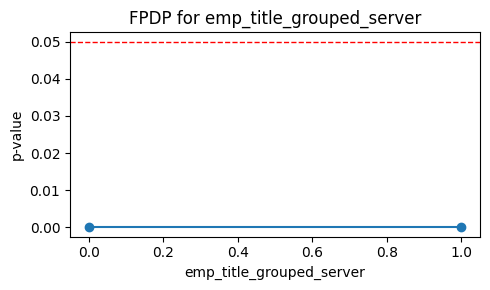

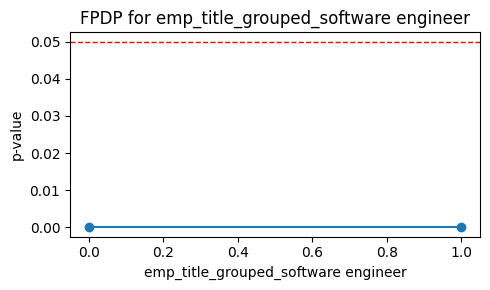

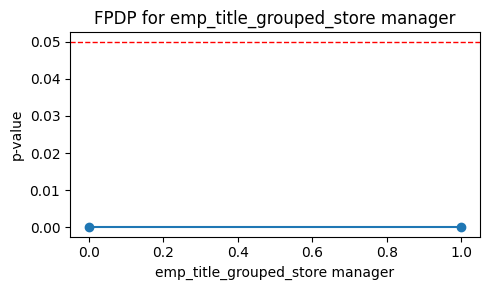

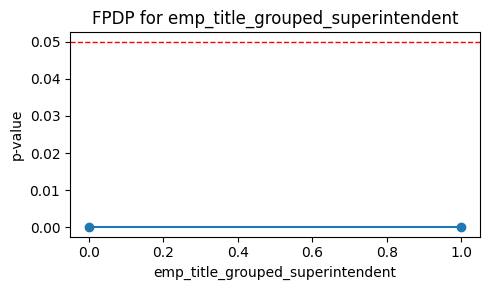

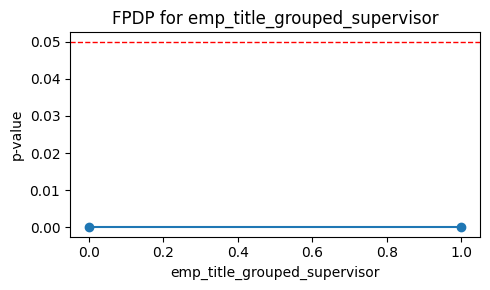

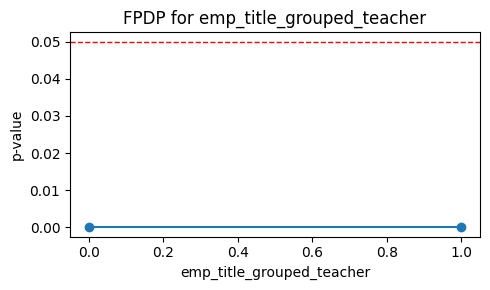

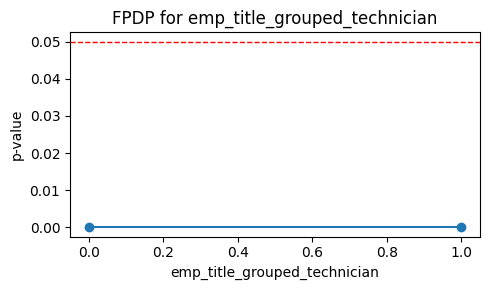

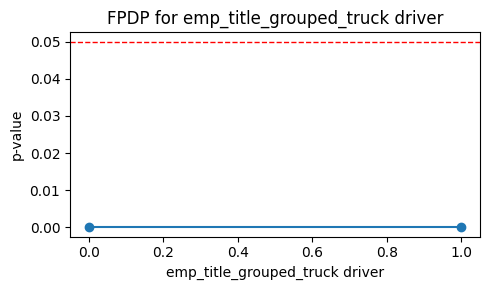

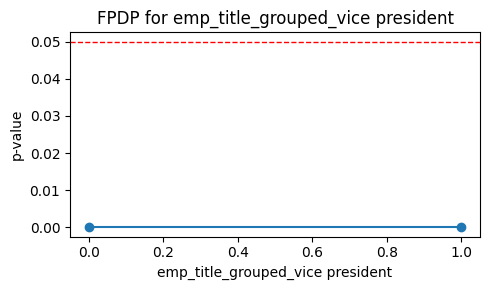

In [79]:
df.drop(columns=["y_pred", "y_actual", "Pct_afro_american"], inplace=True)

figs = fpdp(
    df,
    model=xgb_model,
    protected_col="afroamerican_share_class",
    protected_type="categorical",
    features=list(df.drop(columns="afroamerican_share_class").columns)
)
